Index(['educ_center',
       'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)',
       'harass5_No', 'harass5_Yes', 'harass5_unknown', 'polviews_Conservative',
       'polviews_Extremely_liberal', 'polviews_Extrmly_conservative',
       'polviews_Liberal', 'polviews_Moderate',
       'polviews_Slghtly_conservative', 'polviews_Slightly_liberal',
       'polviews_unknown', 'advfront_Agree', 'advfront_Disagree',
       'advfront_Dont_know', 'advfront_Strongly_agree',
       'advfront_Strongly_disagree', 'advfront_unknown', 'snapchat_No',
       'snapchat_Yes', 'snapchat_unknown', 'instagrm_No', 'instagrm_Yes',
       'instagrm_unknown', 'wrkstat_Keeping_house', 'wrkstat_Other',
       'wrkstat_Retired', 'wrkstat_School', 'wrkstat_Temp_not_working',
       'wrkstat_Unempl,_laid_off', 'wrkstat_Working_fulltime',
       'wrkstat_Working_parttime', 'wrkstat_unknown'],
      dtype='object')
       Formula: email_time_center ~ educ_center + wrkstat_Working_fulltime
        Famil

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [email_time_center_alpha, Intercept, educ_center, wrkstat_Working_fulltime]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   
Intercept                -4.173  0.169  -4.476   -3.847      0.003    0.002  \
educ_center               1.519  0.251   1.036    1.967      0.005    0.003   
wrkstat_Working_fulltime  0.819  0.078   0.679    0.968      0.001    0.001   
email_time_center_alpha   0.564  0.019   0.526    0.598      0.000    0.000   

                          ess_bulk  ess_tail  r_hat  
Intercept                   2787.0    1539.0    1.0  
educ_center                 2735.0    1769.0    1.0  
wrkstat_Working_fulltime    2782.0    1511.0    1.0  
email_time_center_alpha     2863.0    1625.0    1.0  
<xarray.Dataset>
Dimensions:                   (chain: 2, draw: 1000, email_time_center_obs: 413)
Coordinates:
  * chain                     (chain) int64 0 1
  * draw                      (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * email_time_center_obs     (email_time_center_obs) int64 0 1 2 ... 411 412
Data variables:
  

'\nX_train["email_time_center"] = pd.Series(y_train)\nX_train["log_email_time_center"] = X_train["email_time_center"].apply(lambda x: log(x, 10))\nX_train_fulltime = X_train[X_train["wrkstat_Working_fulltime"] == 1]\nX_train_not_fulltime = X_train[X_train["wrkstat_Working_fulltime"] == 0]\nsns.scatterplot(data=X_train_fulltime, y="log_email_time_center", x="educ_center", hue="wrkstat_Working_fulltime")\nplt.show()\nsns.scatterplot(data=X_train_not_fulltime, y="log_email_time_center", x="educ_center", hue="wrkstat_Working_fulltime")\nplt.show()\n'

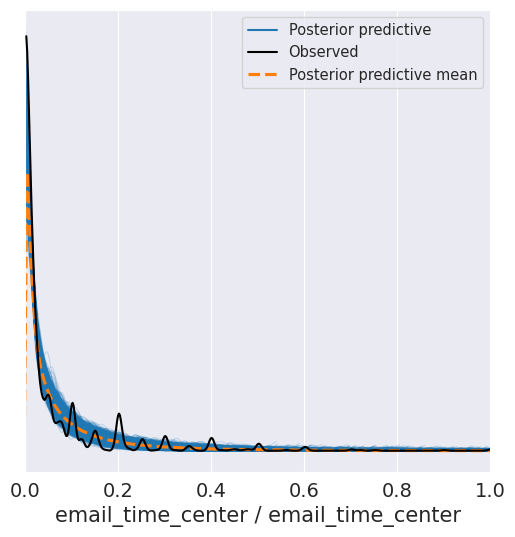

In [4]:
import re
import bambi as bmb
from matplotlib import pyplot as plt
import pandas as pd
import arviz as az
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def final_model(X_train, y_train, X_test, y_test):
    X_train["email_time_center"] = pd.Series(y_train)
    X_test["email_time_center"] = pd.Series(y_test)
    model = bmb.Model(
        """email_time_center ~ educ_center + wrkstat_Working_fulltime""",
        X_train, dropna=True, family="gamma", link="log")
    print(model)

    _, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6))
    ax.set_xlim(xmin=0, xmax=1)
    ax.set_ylim(ymin=0, ymax=1)
    
    results = model.fit(draws=1000, chains=2)
    print(az.summary(results))

    # Diagnostics
    model.predict(results, data=X_test, kind="pps")
    az.plot_ppc(results, ax=ax)
    
    # predict
    model.predict(results, data=X_test, kind="mean")
    print(results.posterior)
    y_predict = np.array(results.posterior.email_time_center_mean[0, 0, :])
    print(y_predict.shape)
    
    mse = mean_squared_error(y_test, y_predict)
    rmse = mean_squared_error(y_test, y_predict, squared=False)
    r2 = r2_score(y_test, y_predict)
    print(f"Test MSE: {mse}")
    print(f"Test RMSE: {rmse}")
    print(f'Test R2 score: {r2}')

# feature_choice = [
#     ["wrkstat_Working_fulltime", "educ_center", "polviews_Conservative"]
# ]
X = pd.read_csv("data/preprocessing/X_fill.csv")
y = pd.read_csv("data/preprocessing/y.csv")["email_time_center"].apply(lambda x: x+0.001)
f = lambda x: re.sub(' ','_', x, flags = re.IGNORECASE)
X.rename(columns = f, inplace = True)
print(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# for index, choice in enumerate(feature_choice):
final_model(X_train, y_train, X_test, y_test)

"""
X_train["email_time_center"] = pd.Series(y_train)
X_train["log_email_time_center"] = X_train["email_time_center"].apply(lambda x: log(x, 10))
X_train_fulltime = X_train[X_train["wrkstat_Working_fulltime"] == 1]
X_train_not_fulltime = X_train[X_train["wrkstat_Working_fulltime"] == 0]
sns.scatterplot(data=X_train_fulltime, y="log_email_time_center", x="educ_center", hue="wrkstat_Working_fulltime")
plt.show()
sns.scatterplot(data=X_train_not_fulltime, y="log_email_time_center", x="educ_center", hue="wrkstat_Working_fulltime")
plt.show()
"""